# Statistics for Dataset

- Number of tigers per image

- % Area in bounding boxes

In [1]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
s3 = boto3.resource('s3')
bucket_name = 'calvinandpogs-ee148'
bucket = s3.Bucket(bucket_name)

## Number of Tigers Per Image

In [3]:
annot_path_test = 'atrw/detection/annotations/yolov5-test/labels/'
annot_path_trainval ='atrw/detection/annotations/yolov5/labels/'

test_tiger_num = [obj.get()['Body'].read().decode("utf-8").count('\n') \
    for obj in bucket.objects.filter(Prefix=annot_path_test)]
trainval_tiger_num = [obj.get()['Body'].read().decode("utf-8").count('\n') \
    for obj in bucket.objects.filter(Prefix=annot_path_trainval)]

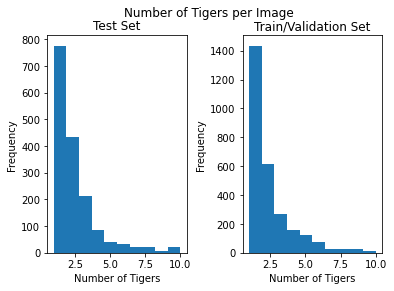

In [4]:
fig = plt.figure()
fig.tight_layout()
fig.suptitle('Number of Tigers per Image')
plt.subplots_adjust(wspace=0.4)

ax1 = fig.add_subplot(121)
ax1.title.set_text('Test Set')
ax1.set_xlabel('Number of Tigers')
ax1.set_ylabel('Frequency')
plt.hist(test_tiger_num)

ax2 = fig.add_subplot(122)
ax2.title.set_text('Train/Validation Set')
ax2.set_xlabel('Number of Tigers')
ax2.set_ylabel('Frequency')
plt.hist(trainval_tiger_num)
#ax2.yaxis.set_label_position("right")
#ax2.yaxis.tick_right()

plt.show()

fig.savefig('../figures/dataset/tigersPerImage.png', dpi=500)

## % Area of Tiger Bounding boxes

Test set: % Area of total image for identified bounding boxes

Ground truth: % Area of total image for ground truth bounding boxes

In [5]:
testm_date = '05-26-2021-23-12-19'
test_date = '05-27-2021-07-47-09'

testm_dir = 'atrw/out/detection/yolov5/test-m/' + testm_date + '/runs/labels/'
test_dir = 'atrw/out/detection/yolov5/test/' + test_date + '/runs/labels/'
truth_dir = 'atrw/detection/annotations/yolov5-test/labels/'

In [6]:
def percent_area(path):
    area_lst = []
    
    for obj in bucket.objects.all():
        if obj.key[0: len(path)] == path:
            body = obj.get()['Body'].read().decode("utf-8")
            boxes = body.split('\n')[:-1]
            
            # calc  % area from yolov5 format: A% = (w/W)*(h/H)
            percent_area = [float(box.split(' ')[-2])*float(box.split(' ')[-1]) for box in boxes]
            
            area_lst = area_lst + percent_area
    return area_lst

In [7]:
perc_area_testm = percent_area(testm_dir)
perc_area_test = percent_area(test_dir)
perc_area_truth = percent_area(truth_dir)

In [8]:
test_df = pd.DataFrame({'% Area': pd.Series(perc_area_test)})
testm_df = pd.DataFrame({'% Area': pd.Series(perc_area_testm)})
truth_df = pd.DataFrame({'% Area': pd.Series(perc_area_truth)})

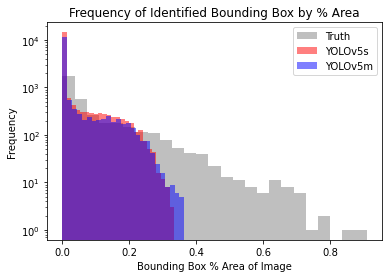

In [9]:
fig2 = plt.figure()

kwargs = dict(alpha=0.5, bins=25)
plt.hist(truth_df, **kwargs, color='grey', label='Truth')
plt.hist(test_df, **kwargs, color='r', label='YOLOv5s')
plt.hist(testm_df, **kwargs, color='b', label='YOLOv5m')

plt.gca().set(title='Frequency of Identified Bounding Box by % Area', \
              xlabel='Bounding Box % Area of Image', ylabel='Frequency')
plt.yscale('log')
plt.legend();

fig2.savefig('../figures/evaluation/percentArea.png', dpi=500)
